# Background

- Now that I have time information, this notebook will use the more refined processed data.

# Imports

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [120]:
from copy import deepcopy
import numpy as np
import pandas as pd
import lmfit as lm
from scipy import optimize
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib notebook

# local imports
from plotting import config_plots, get_label
config_plots()

plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

from load_slow import load_data
from load_survey import *

In [3]:
raw_ddir = '/home/ckampa/Dropbox/LogFiles/survey_12-06-22/'
survey_ddir = '/home/ckampa/Dropbox/LogFiles/Dec22_Survey_Data/'
proc_ddir = 'data/'
plot_dir = 'plots/'

# Load / Inital Processing

In [4]:
# load data
data_file = raw_ddir+'2022-12-06 093302slow.txt'
group_time_file = raw_ddir+'group_time_table_12-06-22_to_12-08-22.txt'

In [5]:
cols = ['Time', 'Magnet Current [A]', 'Magnet Voltage [V]', 'NMR [T]', 'NMR [FFT]',
        'SmarAct_Meas_Angle_1', 'SmarAct_Meas_Rotation_Angle_1', 'SmarAct_Meas_Angle_2', 'SmarAct_Meas_Rotation_Angle_2']

In [6]:
df_slow = load_data(data_file, header=cols).iloc[1:]

In [7]:
df_groups = load_group_df(group_time_file, df_slow)

In [8]:
df_meas, df_groups = construct_meas_df(df_groups, survey_ddir)

In [9]:
df_groups

,Group,Time,seconds_delta,Stage_Removed,SmarAct1_Meas_Deg,SmarAct2_Meas_Deg,SmarAct1_Meas_Rad,SmarAct2_Meas_Rad,Group_Index,can_analyze,all_targets
Datetime,,,,,,,,,,,
2022-12-06 14:10:24,Black Plate Repeatability - 10th Installation ...,12-06-22 14:10:24,16639.0,True,357.999999,346.999992,6.248279,6.056292,0,True,True
2022-12-06 14:20:24,Black Plate Repeatability - 11th Installation,12-06-22 14:20:24,17239.0,True,357.999799,346.999992,6.248275,6.056292,1,True,True
2022-12-06 14:30:24,Black Plate Repeatability - 12th Installation,12-06-22 14:30:24,17839.0,True,357.999995,346.999993,6.248279,6.056292,2,True,True
2022-12-06 14:40:24,Black Plate Repeatability - 13th Installation,12-06-22 14:40:24,18439.0,True,357.999995,347.000003,6.248279,6.056293,3,True,True
2022-12-06 14:50:24,Black Plate Repeatability - 14th Installation,12-06-22 14:50:24,19039.0,True,357.999986,346.999998,6.248278,6.056292,4,True,True
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-08 10:02:10,Black Plate Vertical Rotation 90 Degrees C,12-08-22 10:02:10,174545.0,False,357.999997,89.999996,6.248279,1.570796,84,True,True
2022-12-08 10:05:30,Horizontal -5 Degrees Vertical 90 Degrees C,12-08-22 10:05:30,174745.0,False,354.999993,89.999989,6.195919,1.570796,85,True,True
2022-12-08 10:09:49,Black Plate Vertical Rotation 135 Degrees C,12-08-22 10:09:49,175004.0,False,357.999995,134.999997,6.248279,2.356194,86,True,True


In [10]:
df_groups.query("not can_analyze")

,Group,Time,seconds_delta,Stage_Removed,SmarAct1_Meas_Deg,SmarAct2_Meas_Deg,SmarAct1_Meas_Rad,SmarAct2_Meas_Rad,Group_Index,can_analyze,all_targets
Datetime,,,,,,,,,,,
2022-12-07 15:01:35,Black Plate Vertical Rotation 30 Degrees Check,12-07-22 15:01:35,106110.0,False,358.000004,29.999997,6.248279,0.523599,60,False,False
2022-12-07 15:04:27,Black Plate Horizontal Rotation 0 Degrees Check,12-07-22 15:04:27,106282.0,False,359.999998,347.000000,6.283185,6.056293,61,False,False
2022-12-07 15:07:20,Black Plate Vertical Rotation 315 Degrees Check,12-07-22 15:07:20,106455.0,False,357.999992,314.999996,6.248279,5.497787,62,False,False
2022-12-07 15:08:41,Black Plate Vertical Rotation 180 Degrees Check,12-07-22 15:08:41,106536.0,False,357.999997,179.999993,6.248279,3.141593,63,False,False
2022-12-07 15:10:36,Black Plate Vertical Rotation 90 Degrees Check,12-07-22 15:10:36,106651.0,False,358.000002,90.000001,6.248279,1.570796,64,False,False


In [11]:
df_groups.query("(can_analyze) and (not all_targets)")

,Group,Time,seconds_delta,Stage_Removed,SmarAct1_Meas_Deg,SmarAct2_Meas_Deg,SmarAct1_Meas_Rad,SmarAct2_Meas_Rad,Group_Index,can_analyze,all_targets
Datetime,,,,,,,,,,,
2022-12-08 08:49:16,Black Plate Vertical Rotation 135 Degrees Check,12-08-22 08:49:16,170171.0,False,357.999995,134.999996,6.248279,2.356194,67,True,False
2022-12-08 08:56:16,Black Plate Repeatability - 26th Installation ...,12-08-22 08:56:16,170591.0,True,358.000000,134.999995,6.248279,2.356194,68,True,False


In [12]:
# ONLY LOOK AT GROUPS WE CAN ANALYZE. MAKE SURE I REMEMBER THIS
#df_groups = df_groups.query('can_analyze').copy()
# OR
# ONLY LOOK AT GROUPS WITH ALL TARGETS. MAKE SURE I REMEMBER THIS
df_groups = df_groups.query('all_targets').copy()
# remove any measurements that aren't in the groups being analyzed
df_meas = df_meas[np.isin(df_meas.Group_Index, df_groups.Group_Index)].copy()

In [13]:
# run analysis steps
df_groups = analyze_all_groups_plane(df_groups, df_meas)

Groups: 82
column: norm_v, len of results: 82
column: norm_v_x, len of results: 82
column: norm_v_y, len of results: 82
column: norm_v_z, len of results: 82
column: centroid, len of results: 82
column: centroid_x, len of results: 82
column: centroid_y, len of results: 82
column: centroid_z, len of results: 82
column: vec_y, len of results: 82
column: vec_y_x, len of results: 82
column: vec_y_y, len of results: 82
column: vec_y_z, len of results: 82
column: vec_x, len of results: 82
column: vec_x_x, len of results: 82
column: vec_x_y, len of results: 82
column: vec_x_z, len of results: 82


In [14]:
df_groups

,Group,Time,seconds_delta,Stage_Removed,SmarAct1_Meas_Deg,SmarAct2_Meas_Deg,SmarAct1_Meas_Rad,SmarAct2_Meas_Rad,Group_Index,can_analyze,...,vec_y_x,vec_y_y,vec_y_z,vec_x,vec_x_x,vec_x_y,vec_x_z,dnorm_v_Rad,dnorm_v_Deg,dcentroid
Datetime,,,,,,,,,,,,,,,,,,,,,
2022-12-06 14:10:24,Black Plate Repeatability - 10th Installation ...,12-06-22 14:10:24,16639.0,True,357.999999,346.999992,6.248279,6.056292,0,True,...,-0.015366,0.135423,-0.990669,"[0.00843592122764007, -0.9907329102590897, -0....",0.008436,-0.990733,-0.135562,0.000000,0.000000,0.000000
2022-12-06 14:20:24,Black Plate Repeatability - 11th Installation,12-06-22 14:20:24,17239.0,True,357.999799,346.999992,6.248275,6.056292,1,True,...,-0.015961,0.135716,-0.990619,"[0.008329827347464023, -0.9906930330086997, -0...",0.008330,-0.990693,-0.135860,0.000591,0.033882,0.003789
2022-12-06 14:30:24,Black Plate Repeatability - 12th Installation,12-06-22 14:30:24,17839.0,True,357.999995,346.999993,6.248279,6.056292,2,True,...,-0.013790,0.133320,-0.990977,"[0.005762044179601676, -0.9910442815196192, -0...",0.005762,-0.991044,-0.133409,0.003124,0.179018,0.014879
2022-12-06 14:40:24,Black Plate Repeatability - 13th Installation,12-06-22 14:40:24,18439.0,True,357.999995,347.000003,6.248279,6.056293,3,True,...,-0.015347,0.135749,-0.990624,"[0.006728479486120245, -0.9907046657808206, -0...",0.006728,-0.990705,-0.135864,0.001703,0.097565,0.002602
2022-12-06 14:50:24,Black Plate Repeatability - 14th Installation,12-06-22 14:50:24,19039.0,True,357.999986,346.999998,6.248278,6.056292,4,True,...,-0.015807,0.135701,-0.990624,"[0.006684830747934325, -0.9907109763094498, -0...",0.006685,-0.990711,-0.135820,0.001800,0.103154,0.003978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-08 10:02:10,Black Plate Vertical Rotation 90 Degrees C,12-08-22 10:02:10,174545.0,False,357.999997,89.999996,6.248279,1.570796,84,True,...,-0.007025,0.942286,0.334734,"[-0.01708701413013696, 0.3345803663793403, -0....",-0.017087,0.334580,-0.942212,0.001850,0.106005,0.553892
2022-12-08 10:05:30,Horizontal -5 Degrees Vertical 90 Degrees C,12-08-22 10:05:30,174745.0,False,354.999993,89.999989,6.195919,1.570796,85,True,...,0.042344,0.942399,0.331799,"[0.00021110485630057053, 0.3320886660800678, -...",0.000211,0.332089,-0.943248,0.050539,2.895651,0.551095
2022-12-08 10:09:49,Black Plate Vertical Rotation 135 Degrees C,12-08-22 10:09:49,175004.0,False,357.999995,134.999997,6.248279,2.356194,86,True,...,0.006647,0.432045,0.901828,"[-0.016970739865649304, 0.9017662914716766, -0...",-0.016971,0.901766,-0.431891,0.002065,0.118329,0.684584


In [15]:
df_groups.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 82 entries, 2022-12-06 14:10:24 to 2022-12-08 10:18:55
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Group              82 non-null     object 
 1   Time               82 non-null     object 
 2   seconds_delta      82 non-null     float64
 3   Stage_Removed      82 non-null     bool   
 4   SmarAct1_Meas_Deg  82 non-null     float64
 5   SmarAct2_Meas_Deg  82 non-null     float64
 6   SmarAct1_Meas_Rad  82 non-null     float64
 7   SmarAct2_Meas_Rad  82 non-null     float64
 8   Group_Index        82 non-null     int64  
 9   can_analyze        82 non-null     bool   
 10  all_targets        82 non-null     bool   
 11  norm_v             82 non-null     object 
 12  norm_v_x           82 non-null     float64
 13  norm_v_y           82 non-null     float64
 14  norm_v_z           82 non-null     float64
 15  centroid           82 non-null     obj

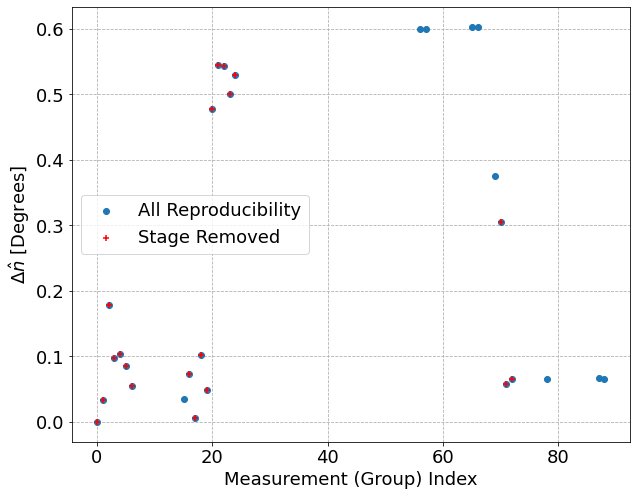

In [41]:
# plot movement of normal vector
df_ = df_groups.iloc[[i for i, g in enumerate(df_groups.Group) if 'Repeat' in g]]
df_rep = df_groups.query("Stage_Removed")

fig, ax = plt.subplots()

ax.scatter(df_.Group_Index, df_.dnorm_v_Deg, label='All Reproducibility')
ax.scatter(df_rep.Group_Index, df_rep.dnorm_v_Deg, c='red', marker='+', label='Stage Removed')

ax.legend()
ax.set_xlabel('Measurement (Group) Index')
ax.set_ylabel(r'$\Delta \hat{n}$ [Degrees]');

In [42]:
df_groups.columns

Index(['Group', 'Time', 'seconds_delta', 'Stage_Removed', 'SmarAct1_Meas_Deg',
       'SmarAct2_Meas_Deg', 'SmarAct1_Meas_Rad', 'SmarAct2_Meas_Rad',
       'Group_Index', 'can_analyze', 'all_targets', 'norm_v', 'norm_v_x',
       'norm_v_y', 'norm_v_z', 'centroid', 'centroid_x', 'centroid_y',
       'centroid_z', 'dnorm_v_Rad', 'dnorm_v_Deg', 'dcentroid'],
      dtype='object')

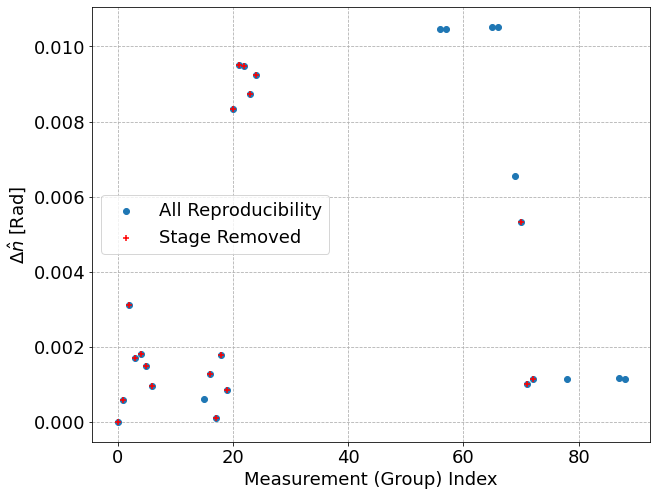

In [43]:
# plot movement of normal vector
df_ = df_groups.iloc[[i for i, g in enumerate(df_groups.Group) if 'Repeat' in g]]
df_rep = df_groups.query("Stage_Removed")

fig, ax = plt.subplots()

ax.scatter(df_.Group_Index, df_.dnorm_v_Rad, label='All Reproducibility')

#ax.scatter(df_rep.Group_Index, 0.006 *np.ones(len(df_rep)), c='red', marker='+')
ax.scatter(df_rep.Group_Index, df_rep.dnorm_v_Rad, c='red', marker='+', label='Stage Removed')

ax.legend()
ax.set_xlabel('Measurement (Group) Index')
ax.set_ylabel(r'$\Delta \hat{n}$ [Rad]');

In [39]:
df_.query('Group_Index < 20')[['dcentroid', 'dnorm_v_Rad']].describe()

,dcentroid,dnorm_v_Rad
count,12.000000,12.000000
mean,0.005496,0.001193
std,0.004841,0.000867
min,0.000000,0.000000
25%,0.002630,0.000612
50%,0.003883,0.001125
75%,0.005816,0.001721
max,0.014879,0.003124


In [40]:
df_.query('Group_Index < 20')[['dcentroid', 'dnorm_v_Rad']]

,dcentroid,dnorm_v_Rad
Datetime,,
2022-12-06 14:10:24,0.000000,0.000000
2022-12-06 14:20:24,0.003789,0.000591
2022-12-06 14:30:24,0.014879,0.003124
2022-12-06 14:40:24,0.002602,0.001703
2022-12-06 14:50:24,0.003978,0.001800
2022-12-06 15:00:24,0.004294,0.001499
2022-12-06 15:10:24,0.003638,0.000967
2022-12-06 15:46:55,0.004320,0.000620
2022-12-07 08:11:31,0.010305,0.001284


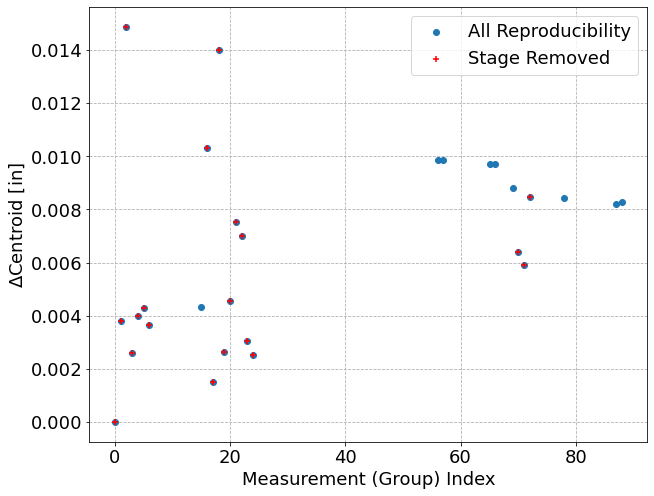

In [30]:
# plot movement of centroid
df_ = df_groups.iloc[[i for i, g in enumerate(df_groups.Group) if 'Repeat' in g]]
df_rep = df_groups.query("Stage_Removed")

fig, ax = plt.subplots()

ax.scatter(df_.Group_Index, df_.dcentroid, label='All Reproducibility')

#ax.scatter(df_rep.Group_Index, 0.006 *np.ones(len(df_rep)), c='red', marker='+')
ax.scatter(df_rep.Group_Index, df_rep.dcentroid, c='red', marker='+', label='Stage Removed')

ax.legend()
ax.set_xlabel('Measurement (Group) Index')
ax.set_ylabel(r'$\Delta$Centroid [in]');

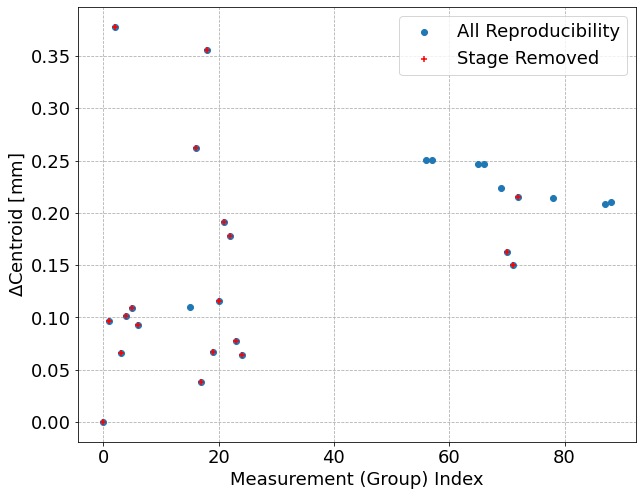

In [31]:
# plot movement of centroid
df_ = df_groups.iloc[[i for i, g in enumerate(df_groups.Group) if 'Repeat' in g]]
df_rep = df_groups.query("Stage_Removed")

fig, ax = plt.subplots()

ax.scatter(df_.Group_Index, inch_to_mm(df_.dcentroid), label='All Reproducibility')

#ax.scatter(df_rep.Group_Index, 0.006 *np.ones(len(df_rep)), c='red', marker='+')
ax.scatter(df_rep.Group_Index, inch_to_mm(df_rep.dcentroid), c='red', marker='+', label='Stage Removed')

ax.legend()
ax.set_xlabel('Measurement (Group) Index')
ax.set_ylabel(r'$\Delta$Centroid [mm]');

In [15]:
df_groups.query('norm_v_x < 0')

,Group,Time,seconds_delta,Stage_Removed,SmarAct1_Meas_Deg,SmarAct2_Meas_Deg,SmarAct1_Meas_Rad,SmarAct2_Meas_Rad,Group_Index,can_analyze,all_targets,norm_v,norm_v_x,norm_v_y,norm_v_z,centroid,centroid_x,centroid_y,centroid_z
Datetime,,,,,,,,,,,,,,,,,,,


In [14]:
df_meas

,Point,X,Y,Z,X_mm,Y_mm,Z_mm,Group,Group_Index,Datetime
0,A,0.122124,1.193630,-1.959151,3.101950,30.318202,-49.762435,Black Plate Repeatability - 10th Installation ...,0,2022-12-06 14:10:24
1,B,0.139268,-0.565170,-2.160190,3.537407,-14.355318,-54.868826,Black Plate Repeatability - 10th Installation ...,0,2022-12-06 14:10:24
2,C,0.170145,-1.336052,-0.441168,4.321683,-33.935721,-11.205667,Black Plate Repeatability - 10th Installation ...,0,2022-12-06 14:10:24
3,D,0.194417,-0.306260,2.005804,4.938192,-7.779004,50.947422,Black Plate Repeatability - 10th Installation ...,0,2022-12-06 14:10:24
4,E,0.151015,1.202173,0.004039,3.835781,30.535194,0.102591,Black Plate Repeatability - 10th Installation ...,0,2022-12-06 14:10:24
...,...,...,...,...,...,...,...,...,...,...
0,A,0.118483,1.150370,-1.985691,3.009468,29.219398,-50.436551,Black Plate Repeatability - 29th Installation ...,88,2022-12-08 10:18:55
1,B,0.138190,-0.612875,-2.144690,3.510026,-15.567025,-54.475126,Black Plate Repeatability - 29th Installation ...,88,2022-12-08 10:18:55
2,C,0.168725,-1.342556,-0.407690,4.285615,-34.100922,-10.355326,Black Plate Repeatability - 29th Installation ...,88,2022-12-08 10:18:55
3,D,0.190342,-0.250500,2.013964,4.834687,-6.362700,51.154686,Black Plate Repeatability - 29th Installation ...,88,2022-12-08 10:18:55


In [15]:
len(df_meas) / len(df_groups)

5.0

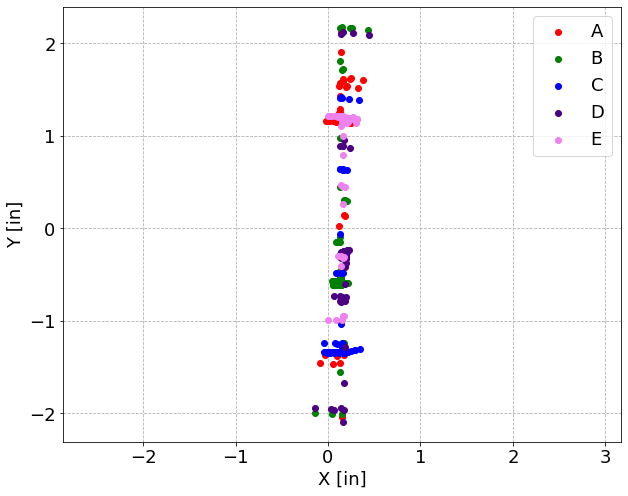

In [16]:
# plot everything, out of curiousity.
fig, ax = plt.subplots()

names = ['A', 'B', 'C', 'D', 'E']
colors = ['red', 'green', 'blue', 'indigo', 'violet']

for n, c in zip(names, colors):
    df_ = df_meas.query(f'Point == "{n}"')
    ax.scatter(df_.X, df_.Y, c=c, label=n)

ax.axis('equal')
    
ax.set_xlabel('X [in]')
ax.set_ylabel('Y [in]')
ax.legend();

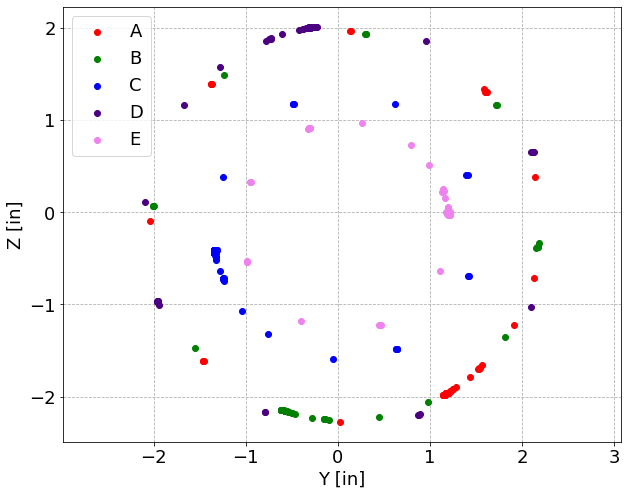

In [17]:
# X, Y plane should show this motion
fig, ax = plt.subplots()

names = ['A', 'B', 'C', 'D', 'E']
colors = ['red', 'green', 'blue', 'indigo', 'violet']

for n, c in zip(names, colors):
    df_ = df_meas.query(f'Point == "{n}"')
    ax.scatter(df_.Y, df_.Z, c=c, label=n)

ax.axis('equal')
    
ax.set_xlabel('Y [in]')
ax.set_ylabel('Z [in]')
ax.legend();

In [17]:
# floor, approximate dimensions
# this is based on laser measurements I did 06-07-21. These are assuming center of magnet gap is center of magnet base
# CAUTION! This also assumes the LT coordinates set up based on the magnet have XY plane completely coplanar with the floor.
ypos_floor = mm_to_inch((0 + 0.838/2 + 1.307)*1e3) # m --> mm --> inch
yneg_floor = mm_to_inch((0 - 0.838/2 - 0.594)*1e3) # m --> mm --> inch
xpos_floor = mm_to_inch((0 + 0.825/2 + 0.270)*1e3) # m --> mm --> inch
xneg_floor = mm_to_inch((0 - 0.825/2 - 0.730)*1e3) # m --> mm --> inch
z_floor_height = -20. # ~17 inch to middle of magnet, plus extra few inches elevated from floor. NOT ACTUALLY SURE....THIS IS A GUESS.
xs_fl = [xneg_floor, xpos_floor]
ys_fl = [yneg_floor, ypos_floor]
X_FL, Y_FL = np.meshgrid(xs_fl, ys_fl)
Z_FL = z_floor_height*np.ones_like(X_FL)
# door
x0_door = xneg_floor
y0_door = (ypos_floor+yneg_floor)/2
Ly_door = 36.
Lz_door = 78.
ys_do = [y0_door-Ly_door/2, y0_door+Ly_door/2]
zs_do = [z_floor_height, z_floor_height+Lz_door]
Y_DO, Z_DO = np.meshgrid(ys_do, zs_do)
X_DO = x0_door*np.ones_like(Y_DO)
# laser tracker, approximate
# Lx_LT = 2.
# Ly_LT = 4.
# Lz_LT = 4.
X0_LT = 1.
Y0_LT = -22.
Z0_LT = 5.
# X_LT = []
# Y_LT = []
# Z_LT = []
# for s_x, s_y in zip([-1, -1, 1, 1], [-1, 1, -1, 1]):
#     X_LT.append([])

In [59]:
(ypos_floor-yneg_floor)

107.83464566929135

In [60]:
mm_to_inch(2.739*1e3)

107.83464566929135

In [62]:
(xpos_floor-xneg_floor)

71.85039370078741

In [63]:
mm_to_inch(1.825*1e3)

71.85039370078741

In [64]:
(ypos_floor+yneg_floor)/2

14.035433070866148

In [61]:
yneg_floor

-39.881889763779526

In [54]:
7*12 +10

94

In [53]:
7*12 +1

85

In [55]:
2.739-1.307-0.594

0.838

In [56]:
1.825 - 0.270 - 0.730

0.825

In [77]:
mm_to_inch(831/2)

16.358267716535433

In [80]:
# plot a single group
group_ind = 0
current_dir = 1
# current_dir = -1

point_dict = {
    'A': 0,
    'B': 1,
    'C': 2,
    'D': 3,
    'E': 4,
}
point_cmap = [
    [0/4, 'red'],
    [1/4, 'green'],
    [2/4, 'blue'],
    [3/4, 'indigo'],
    [4/4, 'violet'],
]

df_m = df_meas.query(f'Group_Index == {group_ind}')
df_g = df_groups.query(f'Group_Index == {group_ind}')

thetas = np.linspace(0, 2*np.pi, 100)
# thetas = np.arange(0, 2*np.pi, 2*np.pi/100)
R = mm_to_inch(250./2)
Rs = np.linspace(0, R, 3)
TH, RR = np.meshgrid(thetas, Rs)
pole_pos = [mm_to_inch(75./2)*np.ones_like(TH), RR*np.cos(TH), RR*np.sin(TH)] # I think this is "South" for positive current --> blue. field points north to south
pole_neg = [mm_to_inch(-75./2*np.ones_like(TH)), RR*np.cos(TH), RR*np.sin(TH)] # I think this is "Norht" for positive current --> red. field points north to south
# pole_pos = [mm_to_inch(75./2)*np.ones_like(thetas), R*np.cos(thetas), R*np.sin(thetas)] # I think this is "South" for positive current --> blue. field points north to south
# pole_neg = [mm_to_inch(-75./2*np.ones_like(thetas)), R*np.cos(thetas), R*np.sin(thetas)] # I think this is "Norht" for positive current --> red. field points north to south
if current_dir > 0:
    pole_labels = ['South', 'North']
    pole_colors = ['blue', 'red']
else:
    pole_labels = ['North', 'South']
    pole_colors = ['red', 'blue']
#cvals = np.ones_like(thetas)
cvals = np.ones_like(TH)

data = [
    # Pole Faces
    go.Surface(x=pole_[0], y=pole_[1], z=pole_[2], surfacecolor=cvals,
               colorscale=[[0,'rgba(0,0,0,0)'],[1,c_]],
               showscale=False,
               showlegend=True,
               #legendgroup=1,
               opacity=0.8,
               name=f'Pole Face ("{p_l}" for Current Direction={current_dir})',
              )
for pole_, c_, p_l in zip([pole_pos, pole_neg], pole_colors, pole_labels)]

# floor
data.append(
    go.Surface(x=X_FL, y=Y_FL, z=Z_FL, surfacecolor=cvals,
               colorscale=[[0,'rgba(0,0,0,0)'],[1,'rgba(130,130,130,0.9)']],
               showscale=False,
               showlegend=True,
               #legendgroup=1,
               #opacity=0.8,
               name=f'Floor (approx., assumes LT coords. XY coplanar to floor)',
              )
)
# door
data.append(
    go.Surface(x=X_DO, y=Y_DO, z=Z_DO, surfacecolor=cvals,
               colorscale=[[0,'rgba(0,0,0,0)'],[1,'rgba(250,247,155,0.9)']],
               showscale=False,
               showlegend=True,
               #legendgroup=1,
               #opacity=0.8,
               name=f'Door',
              )
)

# Laser Tracker approx. location
data.append(go.Scatter3d(x=[X0_LT], y=[Y0_LT], z=[Z0_LT], mode='markers',
                         name='Laser Tracker (approx.)',
                         marker=dict(size=2, color='red', symbol='x',),
#                          hovertemplate=f'{df_m.Point}',
                        )
           )

# data = [
#     # Pole Faces
#     go.Scatter3d(x=pole_[0], y=pole_[1], z=pole_[2], mode='lines+markers',
#                name=f'Pole Face ("{p_l}" for Current Direction={current_dir})',
#               )
# for pole_, c_, p_l in zip([pole_pos, pole_neg], pole_colors, pole_labels)]

# data = [
#     # Pole Faces
#     go.Mesh3d(x=pole_[0], y=pole_[1], z=pole_[2], color=c_, opacity=0.8,
#                name=f'Pole Face ("{p_l}" for Current Direction={current_dir})',
#               )
# for pole_, c_, p_l in zip([pole_pos, pole_neg], pole_colors, pole_labels)]

data.append(go.Scatter3d(x=df_m.X, y=df_m.Y, z=df_m.Z, mode='markers',
                         name='LT Measurements',
                         text=df_m.Point,
                         marker=dict(size=4, color=[point_dict[i] for i in df_m.Point], colorscale=point_cmap),
#                          hovertemplate=f'{df_m.Point}',
                        )
           )

layout = go.Layout(
    title='Survey of SmarAct Kinematic Mounting Plate',
    scene=dict(
        xaxis=dict(title='X [inch]'),
        yaxis=dict(title='Y [inch]'),
        zaxis=dict(title='Z [inch]'),
        aspectmode='data',
    ),
    #plot_bgcolor='rgb(240, 240, 240)',
)

fig = go.Figure(data=data, layout=layout)
fig.write_html(plot_dir+'plotly_3d_test.html')

In [29]:
fig.show()

In [133]:
# slider to select group
current_dir = 1
# current_dir = -1

point_dict = {
    'A': 0,
    'B': 1,
    'C': 2,
    'D': 3,
    'E': 4,
}
point_cmap = [
    [0/4, 'red'],
    [1/4, 'green'],
    [2/4, 'blue'],
    [3/4, 'indigo'],
    [4/4, 'violet'],
]

thetas = np.linspace(0, 2*np.pi, 100)
# thetas = np.arange(0, 2*np.pi, 2*np.pi/100)
R = mm_to_inch(250./2)
Rs = np.linspace(0, R, 3)
TH, RR = np.meshgrid(thetas, Rs)
pole_pos = [mm_to_inch(75./2)*np.ones_like(TH), RR*np.cos(TH), RR*np.sin(TH)] # I think this is "South" for positive current --> blue. field points north to south
pole_neg = [mm_to_inch(-75./2*np.ones_like(TH)), RR*np.cos(TH), RR*np.sin(TH)] # I think this is "Norht" for positive current --> red. field points north to south
# pole_pos = [mm_to_inch(75./2)*np.ones_like(thetas), R*np.cos(thetas), R*np.sin(thetas)] # I think this is "South" for positive current --> blue. field points north to south
# pole_neg = [mm_to_inch(-75./2*np.ones_like(thetas)), R*np.cos(thetas), R*np.sin(thetas)] # I think this is "Norht" for positive current --> red. field points north to south
if current_dir > 0:
    pole_labels = ['South', 'North']
    pole_colors = ['blue', 'red']
else:
    pole_labels = ['North', 'South']
    pole_colors = ['red', 'blue']
#cvals = np.ones_like(thetas)
cvals = np.ones_like(TH)

data = [
    # Pole Faces
    go.Surface(x=pole_[0], y=pole_[1], z=pole_[2], surfacecolor=cvals,
               colorscale=[[0,'rgba(0,0,0,0)'],[1,c_]],
               showscale=False,
               showlegend=True,
               opacity=1.0,
               name=f'Pole Face ("{p_l}" for Current Direction={current_dir})',
              )
for pole_, c_, p_l in zip([pole_pos, pole_neg], pole_colors, pole_labels)]

# floor
data.append(
    go.Surface(x=X_FL, y=Y_FL, z=Z_FL, surfacecolor=cvals,
               colorscale=[[0,'rgba(0,0,0,0)'],[1,'rgba(130,130,130,0.9)']],
               showscale=False,
               showlegend=True,
               opacity=1.0,
               name=f'Floor (approx., assumes LT coords. XY coplanar to floor)',
              )
)
# door
data.append(
    go.Surface(x=X_DO, y=Y_DO, z=Z_DO, surfacecolor=cvals,
               colorscale=[[0,'rgba(0,0,0,0)'],[1,'rgba(250,247,155,0.9)']],
               showscale=False,
               showlegend=True,
               opacity=1.0,
               name=f'Door',
              )
)

# Laser Tracker approx. location
data.append(go.Scatter3d(x=[X0_LT], y=[Y0_LT], z=[Z0_LT], mode='markers',
                         name='Laser Tracker (approx.)',
                         marker=dict(size=2, color='red', symbol='x',),
                         opacity=1.0,
                        )
           )

groups_ind = df_groups.Group_Index.values
groups = df_groups.Group.values
times = df_groups.Time.values
sa1s = df_groups.SmarAct1_Meas_Deg.values
sa2s = df_groups.SmarAct2_Meas_Deg.values

layout = go.Layout(
    title=f'Survey of SmarAct Kinematic Mounting Plate:<br>Group {groups_ind[0]}: {groups[0]}, Time: {times[0]}<br>'+
    f'SmarAct1: {sa1s[0]} [deg], SmarAct2: {sa2s[0]} [deg]',
    #title='Survey of SmarAct Kinematic Mounting Plate',
    scene=dict(
        xaxis=dict(title='X [inch]'),
        yaxis=dict(title='Y [inch]'),
        zaxis=dict(title='Z [inch]'),
        aspectmode='data',
    ),
    #plot_bgcolor='rgb(240, 240, 240)',
)

fig = go.Figure(layout=layout)

for group_ind in groups_ind:
    df_m = df_meas.query(f'Group_Index == {group_ind}')
    df_g = df_groups.query(f'Group_Index == {group_ind}')
    fig.add_trace(go.Scatter3d(x=df_m.X, y=df_m.Y, z=df_m.Z, mode='markers', opacity=1.0,
                             name=f'LT Measurements: {group_ind}',
                             text=df_m.Point,
                             marker=dict(size=4, color=[point_dict[i] for i in df_m.Point], colorscale=point_cmap),
                             visible=False
                            )
               )

# add other traces
for trace in data:
    fig.add_trace(trace)
    
# turn on 0th trace
fig.data[0].visible=True

# set up slider
steps = []
step_inds = [i for i in range(len(df_groups.Group_Index.values))]
n_all_on = len(fig.data) - len(step_inds)
for i in step_inds:
    step = dict(
        method='update',
        args=[{'visible': [False]*len(step_inds) + [True]*n_all_on},
              {'title': f'Survey of SmarAct Kinematic Mounting Plate:<br>Group {groups_ind[i]}: {groups[i]}, Time: {times[i]}<br>'+
              f'SmarAct1: {sa1s[i]} [deg], SmarAct2: {sa2s[i]} [deg]'},
             ],
    )
    step["args"][0]["visible"][i] = True # toggle correct trace on
    steps.append(step)

sliders = [dict(
    active=0,
    currentvalue={'prefix': 'Index: '},
    pad={'t': 50},
    steps=steps
)]

fig.update_layout(
    sliders=sliders
)

# visibility buttons
# just doing one as an example for now...2022-12-15 17:03:29
# probably can not do multiple toggles in this way...a particular toggle sets all values.

# grab default opacity for each trace
default_opacities = [trace['opacity'] for trace in fig.data]
pole_off_opacities = deepcopy(default_opacities)
# pole face is just after the measurement steps
pole_off_opacities[len(step_inds)] = 0.0

# fig.update_layout(
#     updatemenus=[
#         dict(
#             type="buttons",
#             direction="left",
#             active=0,
#             x=1.19,
#             xanchor='left',
#             yanchor='top',
#             y=0.5,
#             buttons=list([
#                 dict(label="On",
#                      method="update",
#                      args=[{"opacity": default_opacities},
#                           ]),
#                 dict(label="Off",
#                      method="update",
#                      args=[{"opacity": pole_off_opacities},
#                           ]),
#             ]),
#         )
#     ]
# )

# Add annotation
# fig.update_layout(
#     annotations=[
#         dict(text="+X Pole Visibility:", showarrow=False,
#              x=1.08, y=0.5, yref="paper", align="left")
#     ]
# )

# camera
camera_default = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=1.25, y=1.25, z=1.25)
)

camera_pos_x = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0.126, y=-0.13, z=-0.2),
    eye=dict(x=0.4, y=-0.13, z=-0.2)
)

camera_pos_z = dict(
    up=dict(x=-1, y=0, z=0),
    center=dict(x=0.126, y=-0.13, z=-0.2),
    eye=dict(x=0.126, y=-0.13, z=0.0)
)

#fig.update_layout(scene_camera=camera_pos_x)
#fig.update_layout(scene_camera=camera_pos_z)

# buttons for camera
fig.update_layout(
    updatemenus=[
        # pole visibility
        dict(
            type="buttons",
            direction="left",
            active=0,
            x=1.19,
            xanchor='left',
            yanchor='top',
            y=0.5,
            buttons=list([
                dict(label="On",
                     method="restyle",
                     args=[{"opacity": default_opacities},
                          ]),
                dict(label="Off",
                     method="restyle",
                     args=[{"opacity": pole_off_opacities},
                          ]),
            ]),
        ),
        # camera
        dict(
            type="buttons",
            direction="left",
            active=0,
            x=1.19,
            xanchor='left',
            yanchor='top',
            y=0.4,
            buttons=list([
                dict(label="Room",
                     method="relayout",
                     args=[{"scene.camera": camera_default},
                          ]),
#                      args=[{"scene.camera.up": camera_default['up']},
#                            {"scene.camera.center": camera_default['center']},
#                            {"scene.camera.eye": camera_default['eye']},
#                           ]),
                dict(label="Side",
                     method="relayout",
                     args=[{"scene.camera": camera_pos_x},
                          ]),
#                      args=[{"scene.camera.up": camera_pos_x['up']},
#                            {"scene.camera.center": camera_pos_x['center']},
#                            {"scene.camera.eye": camera_pos_x['eye']},
#                           ]),
                dict(label="Top",
                     method="relayout",
                     args=[{"scene.camera": camera_pos_z},
                          ]),
#                      args=[{"scene.camera.up": camera_pos_z['up']},
#                            {"scene.camera.center": camera_pos_z['center']},
#                            {"scene.camera.eye": camera_pos_z['eye']},
#                           ]),
            ]),
        ),
        # camera perspective
        dict(
            type="buttons",
            direction="left",
            active=0,
            x=1.19,
            xanchor='left',
            yanchor='top',
            y=0.3,
            buttons=list([
                dict(label="Perspective",
                     method="relayout",
                     args=[{"scene.camera.projection.type": 'perspective'},
                          ]),
                dict(label="Orthographic",
                     method="relayout",
                     args=[{"scene.camera.projection.type": 'orthographic'},
                          ]),
            ]),
        )
    ]
)

# Add annotation
fig.update_layout(
    annotations=[
        dict(text="+X Pole Visibility:", showarrow=False,
             x=1.1, y=0.5, xref="paper", yref="paper", align="left"),
        dict(text="Camera View:", showarrow=False,
             x=1.1, y=0.4, xref="paper", yref="paper", align="left"),
        dict(text="Camera Projection:", showarrow=False,
             x=1.1, y=0.3, xref="paper", yref="paper", align="left"),
    ]
)

#fig = go.Figure(data=data, layout=layout)
fig.write_html(plot_dir+'plotly_3d_test_slider.html')

In [121]:
x0 = (xneg_floor+xpos_floor)/2
xrange = (xpos_floor-xneg_floor)
(0.0 - x0) / xrange

0.12602739726027398

In [119]:
y0 = (yneg_floor+ypos_floor)/2
yrange = (ypos_floor-yneg_floor)
(0.0 - y0) / yrange

-0.13015699160277477

In [120]:
y0

14.035433070866148

In [101]:
fig.data[1]['opacity']

1.0

In [102]:
default_opacities = [trace['opacity'] for trace in fig.data]

In [104]:
fig.data[len(step_inds)]

Surface({
    'colorscale': [[0, 'rgba(0,0,0,0)'], [1, 'blue']],
    'name': 'Pole Face ("South" for Current Direction=1)',
    'opacity': 1.0,
    'showlegend': True,
    'showscale': False,
    'surfacecolor': array([[1., 1., 1., ..., 1., 1., 1.],
                           [1., 1., 1., ..., 1., 1., 1.],
                           [1., 1., 1., ..., 1., 1., 1.]]),
    'x': array([[1.47637795, 1.47637795, 1.47637795, ..., 1.47637795, 1.47637795,
                 1.47637795],
                [1.47637795, 1.47637795, 1.47637795, ..., 1.47637795, 1.47637795,
                 1.47637795],
                [1.47637795, 1.47637795, 1.47637795, ..., 1.47637795, 1.47637795,
                 1.47637795]]),
    'y': array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
                 0.        ],
                [2.46062992, 2.45567588, 2.44083369, ..., 2.44083369, 2.45567588,
                 2.46062992],
                [4.92125984, 4.91135175, 4.88166739, ..., 4.88166739, 

In [31]:
# add analyzed plane
# slider to select group
current_dir = 1
# current_dir = -1

point_dict = {
    'A': 0,
    'B': 1,
    'C': 2,
    'D': 3,
    'E': 4,
}
point_cmap = [
    [0/4, 'red'],
    [1/4, 'green'],
    [2/4, 'blue'],
    [3/4, 'indigo'],
    [4/4, 'violet'],
]

thetas = np.linspace(0, 2*np.pi, 100)
# thetas = np.arange(0, 2*np.pi, 2*np.pi/100)
R = mm_to_inch(250./2)
Rs = np.linspace(0, R, 3)
TH, RR = np.meshgrid(thetas, Rs)
pole_pos = [mm_to_inch(75./2)*np.ones_like(TH), RR*np.cos(TH), RR*np.sin(TH)] # I think this is "South" for positive current --> blue. field points north to south
pole_neg = [mm_to_inch(-75./2*np.ones_like(TH)), RR*np.cos(TH), RR*np.sin(TH)] # I think this is "Norht" for positive current --> red. field points north to south
# pole_pos = [mm_to_inch(75./2)*np.ones_like(thetas), R*np.cos(thetas), R*np.sin(thetas)] # I think this is "South" for positive current --> blue. field points north to south
# pole_neg = [mm_to_inch(-75./2*np.ones_like(thetas)), R*np.cos(thetas), R*np.sin(thetas)] # I think this is "Norht" for positive current --> red. field points north to south
if current_dir > 0:
    pole_labels = ['South', 'North']
    pole_colors = ['blue', 'red']
else:
    pole_labels = ['North', 'South']
    pole_colors = ['red', 'blue']
#cvals = np.ones_like(thetas)
cvals = np.ones_like(TH)

data = [
    # Pole Faces
    go.Surface(x=pole_[0], y=pole_[1], z=pole_[2], surfacecolor=cvals,
               colorscale=[[0,'rgba(0,0,0,0)'],[1,c_]],
               showscale=False,
               showlegend=True,
               opacity=1.0,
               name=f'Pole Face ("{p_l}" for Current Direction={current_dir})',
              )
for pole_, c_, p_l in zip([pole_pos, pole_neg], pole_colors, pole_labels)]

# floor
data.append(
    go.Surface(x=X_FL, y=Y_FL, z=Z_FL, surfacecolor=cvals,
               colorscale=[[0,'rgba(0,0,0,0)'],[1,'rgba(130,130,130,0.9)']],
               showscale=False,
               showlegend=True,
               opacity=1.0,
               name=f'Floor (approx., assumes LT coords. XY coplanar to floor)',
              )
)
# door
data.append(
    go.Surface(x=X_DO, y=Y_DO, z=Z_DO, surfacecolor=cvals,
               colorscale=[[0,'rgba(0,0,0,0)'],[1,'rgba(250,247,155,0.9)']],
               showscale=False,
               showlegend=True,
               opacity=1.0,
               name=f'Door',
              )
)

# Laser Tracker approx. location
data.append(go.Scatter3d(x=[X0_LT], y=[Y0_LT], z=[Z0_LT], mode='markers',
                         name='Laser Tracker (approx.)',
                         marker=dict(size=2, color='red', symbol='x',),
                         opacity=1.0,
                        )
           )

groups_ind = df_groups.Group_Index.values
groups = df_groups.Group.values
times = df_groups.Time.values
sa1s = df_groups.SmarAct1_Meas_Deg.values
sa2s = df_groups.SmarAct2_Meas_Deg.values

layout = go.Layout(
    title=f'Survey of SmarAct Kinematic Mounting Plate:<br>Group {groups_ind[0]}: {groups[0]}, Time: {times[0]}<br>'+
    f'SmarAct1: {sa1s[0]} [deg], SmarAct2: {sa2s[0]} [deg]',
    #title='Survey of SmarAct Kinematic Mounting Plate',
    scene=dict(
        xaxis=dict(title='X [inch]'),
        yaxis=dict(title='Y [inch]'),
        zaxis=dict(title='Z [inch]'),
        aspectmode='data',
    ),
    #plot_bgcolor='rgb(240, 240, 240)',
)

fig = go.Figure(layout=layout)

L_vecs = 3.0 # inch

for group_ind in groups_ind:
    df_m = df_meas.query(f'Group_Index == {group_ind}')
    df_g = df_groups.query(f'Group_Index == {group_ind}').iloc[0]
    fig.add_trace(go.Scatter3d(x=df_m.X, y=df_m.Y, z=df_m.Z, mode='markers', opacity=1.0,
                             name=f'LT Measurements: {group_ind}',
                             text=df_m.Point,
                             marker=dict(size=4, color=[point_dict[i] for i in df_m.Point], colorscale=point_cmap),
                             visible=False
                            )
               )
    fig.add_trace(go.Scatter3d(x=[df_g.centroid_x], y=[df_g.centroid_y], z=[df_g.centroid_z], mode='markers', opacity=1.0,
                             name=f'Centroid: {group_ind}',
#                              text=df_m.Point,
                             marker=dict(size=4, color='black', symbol='circle-open'),
                             visible=False,
                            )
               )
    # normal vector
    fig.add_trace(go.Scatter3d(x=[df_g.centroid_x, df_g.centroid_x+L_vecs*df_g.norm_v_x],
                               y=[df_g.centroid_y, df_g.centroid_y+L_vecs*df_g.norm_v_y],
                               z=[df_g.centroid_z, df_g.centroid_z+L_vecs*df_g.norm_v_z],
                               mode='lines', opacity=1.0,
                             name=f'Normal Vector ("Z"): {group_ind}',
#                              text=df_m.Point,
                             #marker=dict(size=4, color='black', symbol='circle-open'),
                             line=dict(width=2, color='blue'),
                             visible=False,
                            )
               )
    # y vector
    fig.add_trace(go.Scatter3d(x=[df_g.centroid_x, df_g.centroid_x+L_vecs*df_g.vec_y_x],
                               y=[df_g.centroid_y, df_g.centroid_y+L_vecs*df_g.vec_y_y],
                               z=[df_g.centroid_z, df_g.centroid_z+L_vecs*df_g.vec_y_z],
                               mode='lines', opacity=1.0,
                             name=f'"Y" Vector: {group_ind}',
#                              text=df_m.Point,
                             #marker=dict(size=4, color='black', symbol='circle-open'),
                             line=dict(width=2, color='green'),
                             visible=False,
                            )
               )
    # X vector
    fig.add_trace(go.Scatter3d(x=[df_g.centroid_x, df_g.centroid_x+L_vecs*df_g.vec_x_x],
                               y=[df_g.centroid_y, df_g.centroid_y+L_vecs*df_g.vec_x_y],
                               z=[df_g.centroid_z, df_g.centroid_z+L_vecs*df_g.vec_x_z],
                               mode='lines', opacity=1.0,
                             name=f'"Y" Vector: {group_ind}',
#                              text=df_m.Point,
                             #marker=dict(size=4, color='black', symbol='circle-open'),
                             line=dict(width=2, color='red'),
                             visible=False,
                            )
               )

# add other traces
for trace in data:
    fig.add_trace(trace)
    
# turn on 0th trace
fig.data[0].visible=True
fig.data[1].visible=True
fig.data[2].visible=True
fig.data[3].visible=True
fig.data[4].visible=True

# set up slider
steps = []
step_inds = [i for i in range(len(df_groups.Group_Index.values))]
n_all_on = len(fig.data) - len(step_inds)
for i in step_inds:
    step = dict(
        method='update',
        args=[{'visible': [False]*5*len(step_inds) + [True]*n_all_on},
              {'title': f'Survey of SmarAct Kinematic Mounting Plate:<br>Group {groups_ind[i]}: {groups[i]}, Time: {times[i]}<br>'+
              f'SmarAct1: {sa1s[i]} [deg], SmarAct2: {sa2s[i]} [deg]'},
             ],
    )
    step["args"][0]["visible"][5*i] = True # toggle correct trace on -- measurements
    step["args"][0]["visible"][5*i+1] = True # toggle correct trace on -- centroid
    step["args"][0]["visible"][5*i+2] = True # toggle correct trace on -- normal (z) vector
    step["args"][0]["visible"][5*i+3] = True # toggle correct trace on -- y vector
    step["args"][0]["visible"][5*i+4] = True # toggle correct trace on -- x vector
    steps.append(step)

sliders = [dict(
    active=0,
    currentvalue={'prefix': 'Index: '},
    pad={'t': 50},
    steps=steps
)]

fig.update_layout(
    sliders=sliders
)

# visibility buttons
# just doing one as an example for now...2022-12-15 17:03:29
# probably can not do multiple toggles in this way...a particular toggle sets all values.

# grab default opacity for each trace
default_opacities = [trace['opacity'] for trace in fig.data]
pole_off_opacities = deepcopy(default_opacities)
# pole face is just after the measurement steps
#pole_off_opacities[len(step_inds)] = 0.0
pole_off_opacities[5*len(step_inds)] = 0.0

# fig.update_layout(
#     updatemenus=[
#         dict(
#             type="buttons",
#             direction="left",
#             active=0,
#             x=1.19,
#             xanchor='left',
#             yanchor='top',
#             y=0.5,
#             buttons=list([
#                 dict(label="On",
#                      method="update",
#                      args=[{"opacity": default_opacities},
#                           ]),
#                 dict(label="Off",
#                      method="update",
#                      args=[{"opacity": pole_off_opacities},
#                           ]),
#             ]),
#         )
#     ]
# )

# Add annotation
# fig.update_layout(
#     annotations=[
#         dict(text="+X Pole Visibility:", showarrow=False,
#              x=1.08, y=0.5, yref="paper", align="left")
#     ]
# )

# camera
camera_default = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=1.25, y=1.25, z=1.25)
)

camera_pos_x = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0.126, y=-0.13, z=-0.2),
    eye=dict(x=0.4, y=-0.13, z=-0.2)
)

camera_pos_z = dict(
    up=dict(x=-1, y=0, z=0),
    center=dict(x=0.126, y=-0.13, z=-0.2),
    eye=dict(x=0.126, y=-0.13, z=0.0)
)

#fig.update_layout(scene_camera=camera_pos_x)
#fig.update_layout(scene_camera=camera_pos_z)

# buttons for camera
fig.update_layout(
    updatemenus=[
        # pole visibility
        dict(
            type="buttons",
            direction="left",
            active=0,
            x=1.19,
            xanchor='left',
            yanchor='top',
            y=0.5,
            buttons=list([
                dict(label="On",
                     method="restyle",
                     args=[{"opacity": default_opacities},
                          ]),
                dict(label="Off",
                     method="restyle",
                     args=[{"opacity": pole_off_opacities},
                          ]),
            ]),
        ),
        # camera
        dict(
            type="buttons",
            direction="left",
            active=0,
            x=1.19,
            xanchor='left',
            yanchor='top',
            y=0.4,
            buttons=list([
                dict(label="Room",
                     method="relayout",
                     args=[{"scene.camera": camera_default},
                          ]),
#                      args=[{"scene.camera.up": camera_default['up']},
#                            {"scene.camera.center": camera_default['center']},
#                            {"scene.camera.eye": camera_default['eye']},
#                           ]),
                dict(label="Side",
                     method="relayout",
                     args=[{"scene.camera": camera_pos_x},
                          ]),
#                      args=[{"scene.camera.up": camera_pos_x['up']},
#                            {"scene.camera.center": camera_pos_x['center']},
#                            {"scene.camera.eye": camera_pos_x['eye']},
#                           ]),
                dict(label="Top",
                     method="relayout",
                     args=[{"scene.camera": camera_pos_z},
                          ]),
#                      args=[{"scene.camera.up": camera_pos_z['up']},
#                            {"scene.camera.center": camera_pos_z['center']},
#                            {"scene.camera.eye": camera_pos_z['eye']},
#                           ]),
            ]),
        ),
        # camera perspective
#         dict(
#             type="buttons",
#             direction="left",
#             active=0,
#             x=1.19,
#             xanchor='left',
#             yanchor='top',
#             y=0.3,
#             buttons=list([
#                 dict(label="Perspective",
#                      method="relayout",
#                      args=[{"scene.camera.projection.type": 'perspective'},
#                           ]),
#                 dict(label="Orthographic",
#                      method="relayout",
#                      args=[{"scene.camera.projection.type": 'orthographic'},
#                           ]),
#             ]),
#         )
    ]
)

# Add annotation
fig.update_layout(
    annotations=[
        dict(text="+X Pole Visibility:", showarrow=False,
             x=1.1, y=0.5, xref="paper", yref="paper", align="left"),
        dict(text="Camera View:", showarrow=False,
             x=1.1, y=0.4, xref="paper", yref="paper", align="left"),
#         dict(text="Camera Projection:", showarrow=False,
#              x=1.1, y=0.3, xref="paper", yref="paper", align="left"),
    ]
)

#fig = go.Figure(data=data, layout=layout)
fig.write_html(plot_dir+'plotly_3d_test_slider_plane_analysis.html')

In [26]:
for group_ind in groups_ind:
    df_m = df_meas.query(f'Group_Index == {group_ind}')
    df_g = df_groups.query(f'Group_Index == {group_ind}').iloc[0]
    print(df_g.centroid_z)

-0.5101332000000001
-0.5106208000000001
-0.5101829999999998
-0.5105776
-0.5104444
-0.51047
-0.510402
-0.5103430000000001
-0.5103626000000002
-0.5103498000000001
-0.5103442
-0.5103188
-0.5103281999999999
-0.5103154000000001
-0.5103055999999999
-0.5103996
-0.5100606
-0.5101126
-0.5098559999999999
-0.5103242
-0.5100728
-0.509971
-0.5101658000000001
-0.5103076
-0.5102845999999999
-0.5102251999999999
-0.5102205999999999
-0.510194
-0.5101689999999999
-0.5102699999999998
-0.5108651999999998
-0.5113912
-0.5117567999999999
-0.5120322
-0.5095852
-0.4861968
-0.4404014
-0.294916
-0.11439719999999994
0.12132279999999995
0.20119819999999994
0.0727624
-0.18914560000000002
-0.4306697999999999
-0.5090538
-0.5091246
-0.5091272000000001
-0.5092046
-0.5104711999999999
-0.510531
-0.12031360000000002
-0.12068399999999997
0.20112200000000008
0.20116419999999993
-0.1891092
-0.18890339999999992
-0.5094021999999999
-0.5093764000000001
-0.509431
-0.5092611999999999
-0.5092057999999998
-0.5092335999999998
-0.5093

# Asides

## Circles in 3D

- Following this note: https://meshlogic.github.io/posts/jupyter/curve-fitting/fitting-a-circle-to-cluster-of-3d-points/

In [66]:
def circle_3d(t, **params):
    # t must be a scalar
    return params['r'] * np.cos(t) * params['u'] + params['r'] * np.sin(t) * np.cross(params['n'], params['u']) + params['C']

In [313]:
#phi = np.pi/4.
# phi = -np.pi/2
# theta = np.pi/3.

# params = {
#     'r': 1.5,
#     'n': np.array([np.cos(phi) * np.sin(theta), np.sin(phi) * np.sin(theta), np.cos(theta)]),
#     'u': np.array([-np.sin(phi), np.cos(phi), 0.]),
#     'C': np.array([0., 0.5, 1.0])
# }

phi = -30/180*np.pi
theta = 45/180*np.pi

params = {
    'r': 2.5,
    'n': np.array([np.cos(phi) * np.sin(theta), np.sin(phi) * np.sin(theta), np.cos(theta)]),
    'u': np.array([-np.sin(phi), np.cos(phi), 0.]),
    'C': np.array([3., 3., 4.])
}

In [314]:
thetas = np.linspace(0, 2*np.pi, 100)
vecs = np.array([circle_3d(t, **params) for t in thetas])

In [315]:
vecs.shape

(100, 3)

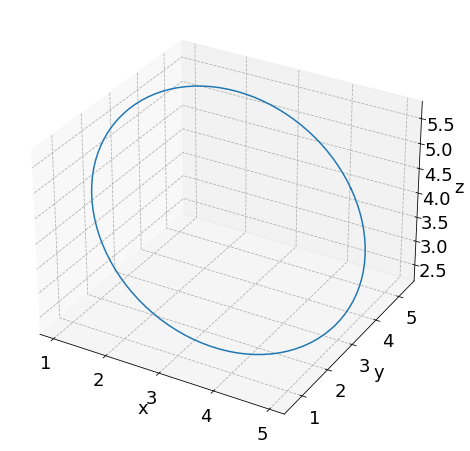

In [316]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot(*vecs.T)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

In [317]:
params['n']

array([ 0.61237244, -0.35355339,  0.70710678])

In [318]:
np.linalg.norm(params['n'])

1.0

In [628]:
# generate some measurements
N = 50
#t_gen = np.random.uniform(low=0, high=np.pi/2, size=N)
#R_gen = params['r'] * (np.random.uniform(low=0.9, high=1.1, size=N))**(1/2)
#vecs_gen = []
#for i in range(len(t_gen)):
#     print(i)
#    params_ = deepcopy(params)
#    params_['r'] = R_gen[i]
#    vecs_gen.append(circle_3d(t_gen[i], **params_))
#vecs_gen = np.array(vecs_gen)
# attempt 2, just add noise to each uniform point
t_gen = np.linspace(0, np.radians(10), N)
# t_gen = np.linspace(0, np.radians(20), N)
#t_gen = np.linspace(0, 3*np.pi/4, N)
#t_gen = np.linspace(0, 3*np.pi/2, N)
# t_gen = np.linspace(0, 2*np.pi, N)
vecs_gen = np.array([circle_3d(t, **params) for t in t_gen])
# add noise?
# vecs_gen += np.random.normal(loc=0, scale=0.01, size=(N, 3))

In [629]:
vecs_gen.shape

(50, 3)

In [630]:
params

{'r': 2.5,
 'n': array([ 0.61237244, -0.35355339,  0.70710678]),
 'u': array([0.5      , 0.8660254, 0.       ]),
 'C': array([3., 3., 4.])}

In [631]:
#params_

In [632]:
#R_gen

In [633]:
#params_['r']

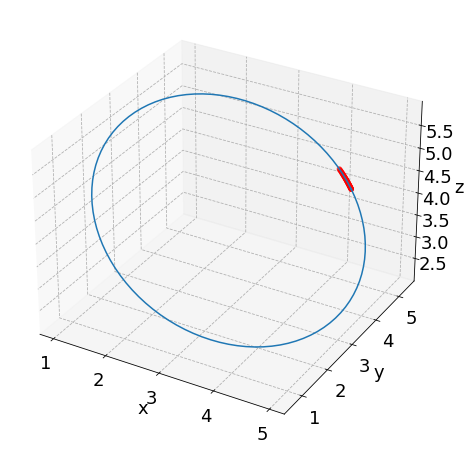

In [634]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot(*vecs.T)
ax.scatter3D(*vecs_gen.T, color='red')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

In [635]:
df_cir = pd.DataFrame({'X': vecs_gen[:, 0], 'Y': vecs_gen[:, 1], 'Z': vecs_gen[:, 2]})

In [636]:
#df_cir

In [643]:
def plane_fit_SVD_circle(df):
    # collect positional points from dataframe
    points = df[['X','Y','Z']].values.T
    # subtract centroid
    centroid = (np.sum(points,axis=1) / len(df))
    points_c = points - centroid[:,None]
    # calculate svd
    u, _, _ = np.linalg.svd(points_c)
    # normal vector is left singular vector with least singular value
    norm_v = u[:,2]
    return norm_v, centroid

# circle fit
def calc_R(xc, yc, x, y):
    return np.sqrt((x-xc)**2 + (y-yc)**2)

def circ_alg_dist(center, x, y):
    Ri = calc_R(*center, x, y)
    return Ri - Ri.mean()

def reco_circle(x, y):
    x_m = np.mean(x)
    y_m = np.mean(y)
    center_est = x_m, y_m
    center_fit, ier = optimize.leastsq(circ_alg_dist, center_est, args=(x, y))
    Ri_fit = calc_R(*center_fit, x, y)
    R_fit = np.mean(Ri_fit)
    R_residual = np.sum((Ri_fit - R_fit)**2)
    return center_fit, R_fit, Ri_fit, R_residual

# cent, R_guess, Ri_fit, R_residual = reco_circle(track_data_rot[1], track_data_rot[2])
# C_x_guess, C_y_guess = cent

def mod_circle(x, y, **params):
    return params['A'] * x + params['B'] * y + params['C'] - x**2 - y**2

def reco_circle_coope(x, y):
    model = lm.Model(mod_circle, independent_vars=['x', 'y'])
    params = lm.Parameters()
    params.add('A', value=np.mean(x)*2)
    params.add('B', value=np.mean(y)*2)
    params.add('C', value=6.3, min=3, max=9)
    result = model.fit(np.zeros_like(x), x=x, y=y, params=params)
    Xc = result.params['A'].value/2
    Yc = result.params['B'].value/2
    R = (result.params['C'].value - Xc**2 - Yc**2)**(1/2)
    result_params = {'Xc':Xc, 'Yc':Yc, 'R': R}
    return result_params, result

def mod_circle_v2(x, y, **params):
    return params['A'] * x + params['B'] * y + params['C']

def reco_circle_coope_v2(x, y):
    model = lm.Model(mod_circle_v2, independent_vars=['x', 'y'])
    params = lm.Parameters()
    params.add('A', value=0.)
    params.add('B', value=0.)
    params.add('R2', value=4., min=0)
    params.add('C', expr='R2 -(A/2)**2 - (B/2)**2')#, min=, max=9)
    result = model.fit(x**2 + y**2, x=x, y=y, params=params)
    Xc = result.params['A'].value/2
    Yc = result.params['B'].value/2
    #R = (result.params['C'].value - Xc**2 - Yc**2)**(1/2)
    R = (result.params['R2'].value)**(1/2)
    result_params = {'Xc':Xc, 'Yc':Yc, 'R': R}
    return result_params, result

In [644]:
# sketching circle fit
# first fit plane
# norm_v, centroid = plane_fit_SVD(df_cir)
norm_v, centroid = plane_fit_SVD_circle(df_cir)
norm_v = norm_v/np.linalg.norm(norm_v)
# theta_ = np.arccos(norm_v[2])
k_vec = np.cross(norm_v, np.array([0, 0, 1]))
# k_vec = -np.cross(np.array([0, 0, 1]), norm_v)
k_vec = k_vec / np.linalg.norm(k_vec)
#costheta = norm_v[2]
#costheta = np.dot(norm_v, k_vec)
costheta = np.dot(norm_v, [0, 0, 1])
sintheta = (1-costheta**2)**(1/2)
# then project onto fit plane (X, Y)
# using Rodrigues' rotation formula
vecs_gen_cen = vecs_gen-centroid
vecs_rot = vecs_gen_cen * costheta + np.cross(k_vec, vecs_gen_cen) * sintheta + np.outer(np.dot(vecs_gen_cen, k_vec), k_vec) * (1 - costheta)
vecs_rot_for = np.array([v * costheta + np.cross(k_vec, v) * sintheta + np.dot(k_vec, v)*k_vec*(1-costheta) for v in vecs_gen_cen])
# vecs_rot = vecs_gen * costheta + np.cross(k_vec, vecs_gen) * sintheta + np.outer(np.dot(vecs_gen, k_vec), k_vec) * (1 - costheta)
# vecs_rot_for = np.array([v * costheta + np.cross(k_vec, v) * sintheta + np.dot(v, k_vec)*k_vec*(1-costheta) for v in vecs_gen])
# fit circle
cent, R_guess, Ri_fit, R_residual = reco_circle(vecs_rot[:,0], vecs_rot[:,1])
# cent, R_guess, Ri_fit, R_residual = reco_circle(vecs_rot_for[:,0], vecs_rot_for[:,1])

In [645]:
# alternative!
#result_params, result = reco_circle_coope(vecs_rot[:,0], vecs_rot[:,1])
result_params, result = reco_circle_coope_v2(vecs_rot[:,0], vecs_rot[:,1])

In [646]:
result_params

{'Xc': -1.055150462821799, 'Yc': -2.262777469700173, 'R': 2.5000000000000138}

In [647]:
result

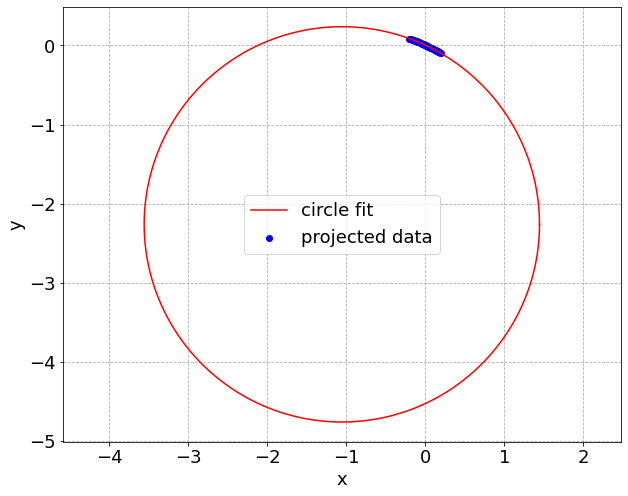

In [648]:
fig, ax = plt.subplots()

t_ = np.linspace(0, 2*np.pi, 361)
x_ = result_params['R']*np.cos(t_) + result_params['Xc']
y_ = result_params['R']*np.sin(t_) + result_params['Yc']

ax.scatter(vecs_rot[:, 0], vecs_rot[:, 1], color='blue', label='projected data')
ax.plot(x_, y_, 'r-', label='circle fit')

ax.axis('equal')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend();

In [581]:
vecs_rot[:,0]

array([-0.67348883, -0.57086543, -0.47136899, -0.37522953, -0.28266931,
       -0.1939023 , -0.10913372, -0.02855952,  0.04763401,  0.11927075,
        0.18618508,  0.2482223 ,  0.30523901,  0.35710339,  0.40369554,
        0.44490776,  0.48064476,  0.51082394,  0.53537552,  0.55424275,
        0.56738201,  0.57476293,  0.57636844,  0.57219483,  0.56225175,
        0.54656219,  0.52516241,  0.49810189,  0.46544318,  0.42726179,
        0.38364599,  0.3346966 ,  0.28052678,  0.22126176,  0.15703855,
        0.08800562,  0.01432256, -0.0638403 , -0.14630225, -0.23287267,
       -0.32335141, -0.41752933, -0.51518869, -0.61610372, -0.72004115,
       -0.82676068, -0.93601561, -1.04755335, -1.16111607, -1.27644122])

In [582]:
vecs_rot[:,1]

array([ 2.41829562,  2.3557092 ,  2.28826232,  2.2161109 ,  2.13942174,
        2.05837212,  1.97314941,  1.88395064,  1.790982  ,  1.69445842,
        1.59460305,  1.49164672,  1.38582746,  1.27738988,  1.16658467,
        1.05366799,  0.93890089,  0.82254866,  0.70488031,  0.58616784,
        0.46668569,  0.34671009,  0.22651839,  0.10638845, -0.01340202,
       -0.1325761 , -0.25085827, -0.3679751 , -0.48365583, -0.59763304,
       -0.70964323, -0.81942747, -0.92673196, -1.03130863, -1.13291573,
       -1.23131836, -1.32628903, -1.4176082 , -1.50506475, -1.58845651,
       -1.6675907 , -1.74228436, -1.81236483, -1.87767009, -1.93804918,
       -1.99336251, -2.0434822 , -2.0882924 , -2.12768951, -2.16158246])

In [531]:
2.5**2

6.25

In [506]:
result.init_params

name,value,initial value,min,max,vary
A,1.5987e-15,1.5987211554602255e-15,-inf,inf,True
B,7.4607e-16,7.460698725481052e-16,-inf,inf,True
C,0.00000000,0,-inf,inf,True


In [482]:
k_vec

array([ 0.5      ,  0.8660254, -0.       ])

In [483]:
np.linalg.norm(norm_v), np.linalg.norm(k_vec)

(1.0, 1.0)

In [484]:
np.allclose(vecs_rot, vecs_rot_for)

True

In [485]:
norm_v

array([-0.61237244,  0.35355339, -0.70710678])

In [486]:
params['n']

array([ 0.61237244, -0.35355339,  0.70710678])

In [487]:
cent

array([7.99360578e-16, 3.73034936e-16])

In [488]:
R_guess

1.4487987948560013

In [489]:
vecs_rot[:,2]

array([ 0.00000000e+00,  1.11022302e-16, -3.33066907e-16, -3.33066907e-16,
       -1.11022302e-16,  0.00000000e+00, -4.44089210e-16, -3.88578059e-16,
       -1.11022302e-16, -4.44089210e-16, -2.77555756e-16, -4.44089210e-16,
       -1.94289029e-16, -1.11022302e-16, -3.74700271e-16, -4.85722573e-16,
       -5.75928194e-16,  3.07046055e-16, -3.81639165e-16,  4.16333634e-17,
        1.94289029e-16, -1.38777878e-16, -1.38777878e-16, -5.55111512e-17,
        2.22044605e-16, -5.55111512e-17, -1.66533454e-16,  1.11022302e-16,
       -1.66533454e-16, -4.44089210e-16,  0.00000000e+00,  5.55111512e-17,
       -1.66533454e-16, -1.11022302e-16, -5.55111512e-16, -1.11022302e-16,
        0.00000000e+00,  0.00000000e+00, -4.99600361e-16,  1.11022302e-16,
       -2.77555756e-16, -2.77555756e-16, -2.77555756e-16,  8.32667268e-17,
       -8.32667268e-17,  1.66533454e-16,  1.80411242e-16,  1.94289029e-16,
        4.57966998e-16,  1.63064007e-16])

In [490]:
vecs_rot[:,2].mean(), vecs_rot[:,2].std(ddof=1)

(-1.2271433869059932e-16, 2.444046888664258e-16)

In [491]:
params['r'], params['C']

(2.5, array([3., 3., 4.]))

In [492]:
R_residual

19.352313417861467

In [493]:
Ri_fit - R_guess

array([ 1.06152806,  0.97509336,  0.8875088 ,  0.79885436,  0.70921587,
        0.61868612,  0.52736637,  0.4353683 ,  0.34281654,  0.2498521 ,
        0.1566369 ,  0.06336001, -0.02975384, -0.12243243, -0.21433945,
       -0.30505094, -0.39402192, -0.48053881, -0.56365293, -0.64209082,
       -0.71414385, -0.7775609 , -0.82951601, -0.86679757, -0.88638734,
       -0.88638734, -0.86679757, -0.82951601, -0.7775609 , -0.71414385,
       -0.64209082, -0.56365293, -0.48053881, -0.39402192, -0.30505094,
       -0.21433945, -0.12243243, -0.02975384,  0.06336001,  0.1566369 ,
        0.2498521 ,  0.34281654,  0.4353683 ,  0.52736637,  0.61868612,
        0.70921587,  0.79885436,  0.8875088 ,  0.97509336,  1.06152806])

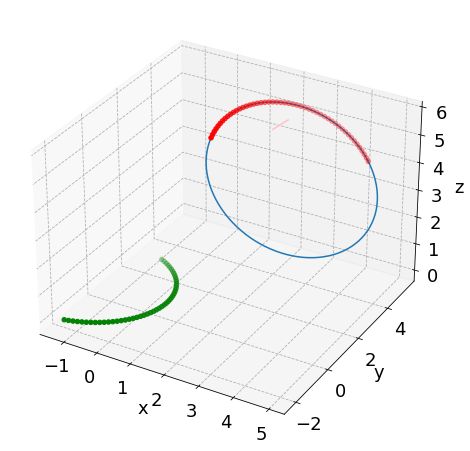

In [480]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot(*vecs.T)
ax.scatter3D(*vecs_gen.T, color='red')
ax.plot([centroid[0], centroid[0]+norm_v[0]], [centroid[1], centroid[1]+norm_v[1]], [centroid[2], centroid[2]+norm_v[2]], color='pink')
ax.scatter3D(*vecs_rot.T, color='green')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

In [116]:
np.allclose(vecs_rot, vecs_rot_for)

True

In [108]:
k_vec

array([-8.66025404e-01,  2.91240381e-16,  0.00000000e+00])

In [106]:
np.dot(vecs_gen, k_vec).shape

(30,)

In [97]:
costheta, sintheta

(0.5, 0.8660254037844386)

In [98]:
(costheta**2 + sintheta**2)**(1/2)

1.0

In [95]:
theta_, theta

(1.0471975511965979, 1.0471975511965976)

In [86]:
norm_v

array([-2.91240381e-16, -8.66025404e-01,  5.00000000e-01])

In [88]:
params['n']

array([ 5.30287619e-17, -8.66025404e-01,  5.00000000e-01])

In [89]:
centroid

array([1.04040059, 0.93856595, 1.75961852])

In [90]:
params['C']

array([0. , 0.5, 1. ])